<a href="https://colab.research.google.com/github/TheClockworkk/studyCUDA/blob/main/course_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Курсовая работа по ПГП**

Студент: Ягфаров Тимур Ильмарович

Группа: М8О-107М-22

In [57]:
! pip install mpi4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
! pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
!mkdir weights

mkdir: cannot create directory ‘weights’: File exists


Загрузка датасета MNIST с torchvision

In [60]:
%%writefile data_set.py

import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt

train_data = datasets.MNIST(
      root = 'data',
      train = True,                         
      transform = ToTensor(), 
      download = True,            
  )

test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

Overwriting data_set.py


Визуализация MNIST

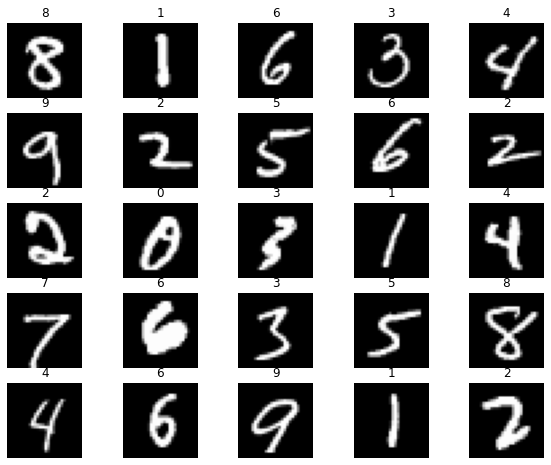

In [61]:
import torch
from data_set import train_data
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Подготовка данных MNIST для обучения через DataLoader

In [62]:
%%writefile data_loader.py
from torch.utils.data import DataLoader
import torch
from data_set import train_data,test_data

def DataLoader(batchSize, numWorkers, shuffle = False,):
  loaders = {
  'train' : torch.utils.data.DataLoader(train_data, batch_size=batchSize, shuffle=shuffle, num_workers=numWorkers),
  'validate'  : torch.utils.data.DataLoader(test_data, batch_size=batchSize, shuffle=True, num_workers=numWorkers)
  }

  return loaders     

Overwriting data_loader.py


Создание модели CNN

In [63]:
%%writefile model.py
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,
                dilation=1,
                groups=1                 
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

Overwriting model.py


In [64]:
%%writefile main.py
from mpi4py import MPI
import torch.optim as optim
import torch
from data_loader import DataLoader
from torch.autograd import Variable
from model import CNN
import torch.nn as nn
from tqdm import tqdm

def train_model(num_epochs,
                criterion,
                test_dataloader,
                rank,
                batch_size,
                optimizer,
                model,
                train_dataloader,
                val_dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model_best = 0

    for epoch in range(num_epochs):
      running_loss = 0
      accuracy = 0

      dataset_sizes_train = len(train_dataloader)
      model.train()

      if rank == 0:
        i = 0
        for images, labels in tqdm(train_dataloader):
          comm.send((images, labels),dest = i%(p-1)+1)
          i+=1

      if rank != 0:
        for i in range(len(train_dataloader)):    
          if i % (p - 1) + 1 == rank:
            (images,lables) = comm.recv(source=0)
            images = images.to(device)
            lables = lables.to(device)

            output = model(images)
            loss = criterion(output,lables)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)

        running_loss = running_loss / dataset_sizes_train
        print("Epoch of train:", epoch + 1,"Loss: [", running_loss, "]", "rank: ", rank)
            
      MPI.Comm.Barrier(MPI.COMM_WORLD)
      
      accuracy = 0
      validate_loss = 0.0
      dataset_sizes_val = len(val_dataloader)

      if rank != 0:
        model.eval()

      if rank == 0:
        i = 0
        for images, labels in tqdm(val_dataloader):
          comm.send((images,labels), dest=i % (p - 1) + 1)
          i+=1

      if rank != 0:
        for i in range(len(val_dataloader)):    
          if i % (p - 1) + 1 == rank:
            (images,lables) = comm.recv(source=0)
            images = images.to(device)
            lables = lables.to(device)

            with torch.no_grad():
              output = model(images)
              loss = criterion(output,lables)
              validate_loss += loss.item() * images.size(0)
              pred_y = torch.max(output, 1)[1].data.squeeze()
        validate_loss = validate_loss / dataset_sizes_val
        print("Epoch of validation:", epoch + 1,"Loss: ",validate_loss, rank)

      MPI.Comm.Barrier(MPI.COMM_WORLD) 

      if rank != 0: 
        if epoch == 0:
          model_best = validate_loss

        if validate_loss <= model_best:
          model_best = validate_loss
          torch.save(model.state_dict(), f"./weights/model_{rank}.pth")
    return model

if __name__ == "__main__":

  comm = MPI.COMM_WORLD
  my_rank = comm.Get_rank()
  p = comm.Get_size()
  num_epochs = 5
  batch_size = 20
  num_workers = 6
  train_dataloader = DataLoader(batch_size,num_workers)['train']
  validate_dataloader = DataLoader(batch_size,num_workers)['validate']
  model = CNN()
  optimizer = optim.Adam(model.parameters(), lr=0.01)
  criterion = nn.CrossEntropyLoss()
  model = train_model(num_epochs,criterion,validate_dataloader,my_rank,
                           batch_size,optimizer,model,train_dataloader,validate_dataloader)
  MPI.Finalize               

Overwriting main.py


In [65]:
! mpirun --allow-run-as-root -np 4 --oversubscribe python main.py


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 3000/3000 [03:08<00:00, 15.90it/s]Epoch of train: 1 Loss: [ 1.6566271770635892 ] rank:  1
Epoch of train: 1 Loss: [ 1.2319381663999713 ] rank:  2
Epoch of train: 1 Loss: [ 1.4251239491550465 ] rank:  3

100%|██████████| 500/500 [00:13<00:00, 37.87it/s]Epoch of validation: 1 Loss:  0.9761182161350734 3
Epoch of validation: 1 Loss:  0.47319767871216756 2
Epoch of validation: 1 Loss:  0.9079794497229159 1

100%|██████████| 3000/3000 [03:00<00:00, 16.62it/s]Epoch of train: 2 Loss: [ 0.8695978254570703 ] rank

In [66]:
%%writefile test.py
from mpi4py import MPI
import torch.optim as optim
import torch
from data_loader import DataLoader
from torch.autograd import Variable
from model import CNN
import torch.nn as nn
from tqdm import tqdm

def test(model, criterion, dataloader_test, dataset_sizes_test):
    score = 0
    runing_loss = 0.0
    model.eval()

    with torch.no_grad():
        if rank != 0:
            print("Start proccess number ",rank)
            for image, label in tqdm(dataloader_test): 
                output = model(image)
                comm.send(output, dest=0, tag=0) 
                if rank == 1:
                    comm.send(label, dest=0, tag=1)
                _, preds = torch.max(output, 1)
                loss = criterion(output, label)
                runing_loss += loss.item() * image.size(0)
                score += torch.sum(preds == label.data)

            epoch_acc = score.double() / dataset_sizes_test
            runing_loss = runing_loss / dataset_sizes_test
            print("Test process ", rank, ": score: [", epoch_acc.item(), "], loss: [", runing_loss, "]")
        
        MPI.Comm.Barrier(MPI.COMM_WORLD)
        result = 0

        if rank == 0:
            print("Start proccess number ",rank)
            for i in tqdm(range(len(dataloader_test))):
                label = comm.recv(source=1, tag=1) 
                for procid in range(1, p):
                    output = comm.recv(source=procid, tag=0)

                    if procid == 1:
                        result_all_models = output

                    else:
                        result_all_models += output

                _, preds = torch.max(result_all_models, 1)
                result += torch.sum(preds == label.data)

            result = result.double() / dataset_sizes_test
            print("Test process result", rank, result.item())

if __name__ == "__main__":

  comm = MPI.COMM_WORLD
  rank = comm.Get_rank()
  p = comm.Get_size()
  num_epochs = 5
  batch_size = 20
  num_workers = 6
  train_dataloader = DataLoader(batch_size,num_workers)['train']
  validate_dataloader = DataLoader(batch_size,num_workers)['validate']
  model = CNN()

  if(rank != 0):
     model.load_state_dict(torch.load(f'/content/weights/model_{rank}.pth'))
  optimizer = optim.Adam(model.parameters(), lr=0.01)
  criterion = nn.CrossEntropyLoss()
  model = test(model,criterion,validate_dataloader,len(validate_dataloader) * batch_size)
  
  MPI.Finalize    

Overwriting test.py


In [67]:
! mpirun --allow-run-as-root -np 4 --oversubscribe python test.py


Start proccess number  1
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/500 [00:00<?, ?it/s]Start proccess number  3
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
